# Prostate_GE Dataset: k-Stability Experiments
Experiments to show that there exist features that are k-unstable.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio

from sklearn.linear_model import Lasso
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler

## Load dataset
Load the Prostate_GE dataset. There are 102 instances, 5966 features and a binary outcome variable in the set \{0, 1\}. We standardize by subtracting the mean and dividing by the std. deviation.

The Prostate_GEdata set contains 102 patients either with or without prostate cancer. Each of the 5966 features represents one gene in each patient, and the outcome variable represents cancer.

In [2]:
mat_file = sio.loadmat('./data/Prostate_GE.mat')
X = mat_file['X']
y = mat_file['Y']
print(np.shape(X))
print(np.shape(y))
print(X[:5])
print(y[:5])

(102, 5966)
(102, 1)
[[1.07554696 1.15836249 1.25042    ... 1.14612804 1.28555731 1.57170883]
 [1.         1.         1.11394335 ... 1.         1.         1.41497335]
 [1.70757018 1.71600334 1.         ... 1.         1.         1.        ]
 [1.17609126 1.32221929 1.90308999 ... 1.39794001 1.         1.        ]
 [1.59106461 1.39794001 1.         ... 1.50514998 1.47712125 1.        ]]
[[1]
 [1]
 [1]
 [1]
 [1]]


In [3]:
# normalize the dataset 
scaler = StandardScaler()
X = scaler.fit_transform(X)
y_mean = np.mean(y)
y_std = np.std(y)
y = (y - y_mean)/y_std
print(X[:5])
print(y[:5])

[[-0.36406986  0.04456789  0.34927425 ...  0.44559441  0.28679957
   1.7584565 ]
 [-0.65835834 -0.62901052 -0.26042637 ... -0.49421087 -0.601297
   0.9338336 ]
 [ 2.09793712  2.4164353  -0.76946094 ... -0.49421087 -0.601297
  -1.24944052]
 [ 0.02759417  0.74151577  3.26503526 ...  2.0650935  -0.601297
  -1.24944052]
 [ 1.64409695  1.06358596 -0.76946094 ...  2.75460181  0.88257239
  -1.24944052]]
[[-1.0198039]
 [-1.0198039]
 [-1.0198039]
 [-1.0198039]
 [-1.0198039]]


## LASSO Model
We use Lasso Regression to find the k-unstable features. Following optimization problem:

$$\min_{\theta} \frac{1}{n} \cdot \|Y - X\theta|_2^2 + \frac{2\lambda}{n} \cdot \|\theta\|_1$$

Because Lasso induces sparsity on the resulting $\theta$ vector of the model (typically used for feature selection), we find all the features that get set to 0, and call this our "target set." We aim to loop through the features in our "target set" and find the smallest value of $k$ (the number of poison rows) that adds that specific feature to $\theta$. 

sklearn's implementation of LASSO, that we're using here, is the following equivalent optimization problem, with hyperparameter $\alpha$:

$$\min_{\theta} \frac{1}{2n} \|Y - X \theta\|_2^2 + \alpha \|\theta\|_1$$

In [4]:
# TODO: get a more systematic way to find alpha
alpha_val = 0.05
lasso = Lasso(alpha=alpha_val) # default: alpha = 1.0
lasso_coef = lasso.fit(X,y).coef_
print(np.where(lasso_coef > 0)[0])
print("Number of positive nonzero entries at alpha={}: {}".format(alpha_val, len(lasso_coef[lasso_coef > 0])))

[ 191  218  696 1026 1715 1815 1921 2175 2349 2585 2600 3380 3449 3960
 4162 4977 5483 5691]
Number of positive nonzero entries at alpha=0.05: 18


In [5]:
# Initialize the support and set of poisoning targets
support = np.where(abs(lasso_coef) > 1.e-6)[0]
target_set = np.where(abs(lasso_coef) <= 1e-6)[0]
print(target_set)

[   0    1    2 ... 5963 5964 5965]


### Poisoning Attack
We follow the poisoning attack proposed in **Theorem 4.5** and **Construction 4.6**. That is, for some $k$, the number of posion rows, we generate:

$$X_p = \left[ {\begin{array}{cccc}
   0 & \dots & 1 & \dots & 0 \\
   \vdots & \ddots & \vdots & \ddots & \vdots \\
   0 & \dots & 1 & \dots & 0 \\
  \end{array} } 
  \right]
$$

for the features of our attack, and 

$$Y_p = \left[ {\begin{array}{c}
   1 \\
   \vdots \\
   1
  \end{array} } 
  \right]
$$

for the outcome variable of our attack. Then, for $X_0$ and $Y_0$ our original dataset, we append the poison rows $X_p$ and $Y_p$ to get:

$$\left[ {\begin{array}{c|c}
   X_0 & Y_0 \\
   X_p & Y_p \\
  \end{array} } 
  \right]
$$

In [6]:
# takes the number of rows to poison, fits a LASSO on the poisoned dataset
def poisoned_lasso(target, poison_rows, X, y): 
    # Generate poison vectors
    X_poison = np.zeros(shape=(poison_rows, len(X[0])))
    X_poison[:, target] += 1 # switch last column to 1's
    y_poison = np.ones(poison_rows)        

    # Poisoned datasets
    X_poisoned = np.vstack([X, X_poison])
    y_poisoned = np.append(y, y_poison)
    
    poisoned_lasso = lasso.fit(X_poisoned,y_poisoned)
    return poisoned_lasso.coef_[target], poisoned_lasso.coef_

def plot_features_k_full(target_k_dict):
    mean_k = np.asarray(list(target_k_dict.values())).mean()
    plt.figure(figsize=(20, 3))
    
    # Set color of minimum feature
    colors = ['c']*len(list(target_k_dict.values()))
    colors[0] = 'r'
            
    plt.bar(range(len(target_k_dict)), list(target_k_dict.values()), align='center', color=colors)
    x_ticks = []
    #for key in list(target_k_dict.keys()):
    #    x_ticks.append(str(key))
    #plt.xticks(range(len(target_k_dict)), x_ticks, rotation=90)
    plt.xticks([], [])
    plt.axhline(y=mean_k,linewidth=1, color='r')
    plt.xlabel("Features Not in Supp")
    plt.ylabel("Minimum k to add to Supp")
    plt.show()
    
def plot_features_k_random_subset(target_k_dict, size):
    mean_k = np.asarray(list(target_k_dict.values())).mean()
    plt.figure(figsize=(20, 3))
    
    # Set color of minimum feature
    colors = ['c']*len(list(target_k_dict.values()))
    colors[0] = 'r'
    
    min_feature = list(target_k_dict.keys())[0]
    min_value = list(target_k_dict.values())[0]
    
    # Randomly sample 'size' number of features to graph (NOT including the minimum)
    target_keys = list(target_k_dict.keys()).copy()
    target_keys.remove(min_feature)
    subset_features = np.random.choice(target_keys, size, replace=False)
    subset_values = []
    for feature in subset_features:
        subset_values.append(target_k_dict[feature])
        
    # Append min feature and value to start of lists
    subset_features = np.insert(subset_features, 0, min_feature)
    subset_values = np.insert(subset_values, 0, min_value)
    
    plt.bar(range(len(subset_features)), subset_values, align='center', color=colors)
    x_ticks = []
    for key in subset_features:
        x_ticks.append(str(key))
    plt.xticks(range(len(subset_features)), x_ticks, rotation=90)
    plt.axhline(y=mean_k,linewidth=1, color='r')
    plt.title("SMK k-stability")
    plt.xlabel("Features Not in Supp")
    plt.ylabel("Minimum k to add to Supp")
    plt.show()

### Experiment Setup
We aim to find features that exhibit k-unstability, as compared to the other features in our dataset. To do this, we iteratively attempt the poison attack on each feature $i$, varying $k$ (the number of rows in our poison attack) until we find the smallest $k$ that adds $i$ to the sparse LASSO vector ("adding" meaning making its value positive). Do this for each feature. 

Because there are 5966 features, we do this on random subsets of 50 features from the 5966. We take 5 of these subsets and check the results.

Conjecture: there exist some features that are much more k-unstable than others, i.e. the $k$ needed to poison that feature is substantially lower than the average value of $k$ across all features.

## Binary Search

In [7]:
# Binary Search for k-values
# can't really do this because, at some point, they just all go to 0 again. 
# one possible solution if we really need binary search: try over a set of possible K_RANGES
K_RANGE = 1000
k_values = list(range(K_RANGE))
target_k_dict = dict()

for target in target_set:
    print("Feature {}".format(target))
    first = 0
    last = K_RANGE - 1
    found = False
    while(first <= last and not found):
        mid = (first + last)//2
        coef, _ = poisoned_lasso(target, mid, X, y)
        if(abs(coef) > 1e-6):
            prev_coef, _ = poisoned_lasso(target, mid - 1, X, y)
            if(abs(prev_coef) <= 1e-6):
                found = True
                target_k_dict[target] = mid
            else:
                last = mid - 1
        else:
            first = mid + 1
            
sorted_target_k_dict = {k: v for k, v in sorted(target_k_dict.items(), key=lambda item: item[1])}

Feature 0
Feature 1
Feature 2
Feature 3
Feature 4
Feature 5
Feature 6
Feature 7
Feature 8
Feature 9
Feature 10
Feature 11
Feature 12
Feature 13
Feature 14
Feature 15
Feature 16
Feature 17
Feature 18
Feature 19
Feature 20
Feature 21
Feature 22
Feature 23
Feature 24
Feature 25
Feature 26
Feature 27
Feature 28
Feature 29
Feature 30
Feature 31
Feature 32
Feature 33
Feature 34
Feature 35
Feature 36
Feature 37
Feature 38
Feature 39
Feature 40
Feature 41
Feature 42
Feature 43
Feature 44
Feature 45
Feature 46
Feature 47
Feature 48
Feature 49
Feature 50
Feature 51
Feature 52
Feature 53
Feature 54
Feature 55
Feature 56
Feature 57
Feature 58
Feature 59
Feature 60
Feature 61
Feature 62
Feature 63
Feature 64
Feature 65
Feature 66
Feature 67
Feature 68
Feature 69
Feature 70
Feature 71
Feature 72
Feature 73
Feature 74
Feature 75
Feature 76
Feature 77
Feature 78
Feature 79
Feature 80
Feature 81
Feature 82
Feature 83
Feature 84
Feature 85
Feature 86
Feature 87
Feature 88
Feature 89
Feature 90
Feature 9

Feature 695
Feature 697
Feature 698
Feature 699
Feature 700
Feature 701
Feature 702
Feature 703
Feature 704
Feature 705
Feature 706
Feature 707
Feature 708
Feature 709
Feature 710
Feature 711
Feature 712
Feature 713
Feature 714
Feature 715
Feature 716
Feature 717
Feature 718
Feature 719
Feature 720
Feature 721
Feature 722
Feature 723
Feature 724
Feature 725
Feature 726
Feature 727
Feature 728
Feature 729
Feature 730
Feature 731
Feature 732
Feature 733
Feature 734
Feature 735
Feature 736
Feature 737
Feature 738
Feature 739
Feature 740
Feature 741
Feature 742
Feature 743
Feature 744
Feature 745
Feature 746
Feature 747
Feature 748
Feature 749
Feature 750
Feature 751
Feature 752
Feature 753
Feature 754
Feature 755
Feature 756
Feature 757
Feature 758
Feature 759
Feature 760
Feature 761
Feature 762
Feature 763
Feature 764
Feature 765
Feature 766
Feature 767
Feature 768
Feature 769
Feature 770
Feature 771
Feature 772
Feature 774
Feature 775
Feature 776
Feature 777
Feature 778
Feature 779
Feat

Feature 1354
Feature 1355
Feature 1356
Feature 1357
Feature 1358
Feature 1359
Feature 1360
Feature 1361
Feature 1362
Feature 1363
Feature 1364
Feature 1365
Feature 1366
Feature 1367
Feature 1368
Feature 1369
Feature 1370
Feature 1371
Feature 1372
Feature 1373
Feature 1374
Feature 1375
Feature 1376
Feature 1377
Feature 1378
Feature 1379
Feature 1380
Feature 1381
Feature 1382
Feature 1383
Feature 1384
Feature 1385
Feature 1386
Feature 1387
Feature 1388
Feature 1389
Feature 1390
Feature 1391
Feature 1392
Feature 1393
Feature 1394
Feature 1395
Feature 1396
Feature 1397
Feature 1398
Feature 1399
Feature 1400
Feature 1401
Feature 1402
Feature 1403
Feature 1404
Feature 1405
Feature 1406
Feature 1407
Feature 1408
Feature 1409
Feature 1410
Feature 1411
Feature 1412
Feature 1413
Feature 1414
Feature 1415
Feature 1416
Feature 1417
Feature 1418
Feature 1419
Feature 1420
Feature 1421
Feature 1422
Feature 1423
Feature 1424
Feature 1425
Feature 1426
Feature 1427
Feature 1428
Feature 1429
Feature 1430

Feature 2039
Feature 2040
Feature 2041
Feature 2042
Feature 2043
Feature 2044
Feature 2045
Feature 2046
Feature 2047
Feature 2048
Feature 2049
Feature 2050
Feature 2051
Feature 2052
Feature 2053
Feature 2054
Feature 2055
Feature 2056
Feature 2057
Feature 2058
Feature 2059
Feature 2060
Feature 2061
Feature 2062
Feature 2063
Feature 2064
Feature 2065
Feature 2066
Feature 2067
Feature 2068
Feature 2069
Feature 2070
Feature 2071
Feature 2072
Feature 2073
Feature 2074
Feature 2075
Feature 2076
Feature 2077
Feature 2078
Feature 2079
Feature 2080
Feature 2081
Feature 2082
Feature 2083
Feature 2084
Feature 2085
Feature 2086
Feature 2087
Feature 2088
Feature 2089
Feature 2090
Feature 2091
Feature 2092
Feature 2093
Feature 2094
Feature 2095
Feature 2096
Feature 2097
Feature 2098
Feature 2099
Feature 2100
Feature 2101
Feature 2102
Feature 2103
Feature 2104
Feature 2105
Feature 2106
Feature 2108
Feature 2109
Feature 2110
Feature 2111
Feature 2112
Feature 2113
Feature 2114
Feature 2115
Feature 2116

Feature 2680
Feature 2681
Feature 2682
Feature 2683
Feature 2684
Feature 2685
Feature 2686
Feature 2687
Feature 2688
Feature 2689
Feature 2690
Feature 2691
Feature 2692
Feature 2693
Feature 2694
Feature 2695
Feature 2696
Feature 2697
Feature 2698
Feature 2699
Feature 2700
Feature 2701
Feature 2702
Feature 2703
Feature 2704
Feature 2705
Feature 2706
Feature 2707
Feature 2708
Feature 2709
Feature 2711
Feature 2712
Feature 2713
Feature 2714
Feature 2715
Feature 2716
Feature 2717
Feature 2718
Feature 2719
Feature 2720
Feature 2721
Feature 2722
Feature 2723
Feature 2724
Feature 2725
Feature 2726
Feature 2727
Feature 2728
Feature 2729
Feature 2730
Feature 2731
Feature 2732
Feature 2733
Feature 2734
Feature 2735
Feature 2736
Feature 2737
Feature 2738
Feature 2739
Feature 2740
Feature 2741
Feature 2742
Feature 2743
Feature 2744
Feature 2745
Feature 2746
Feature 2747
Feature 2748
Feature 2749
Feature 2750
Feature 2751
Feature 2752
Feature 2753
Feature 2754
Feature 2755
Feature 2756
Feature 2757

Feature 3313
Feature 3314
Feature 3315
Feature 3316
Feature 3317
Feature 3318
Feature 3319
Feature 3320
Feature 3321
Feature 3322
Feature 3323
Feature 3324
Feature 3325
Feature 3326
Feature 3327
Feature 3328
Feature 3329
Feature 3330
Feature 3331
Feature 3332
Feature 3333
Feature 3334
Feature 3335
Feature 3336
Feature 3337
Feature 3338
Feature 3339
Feature 3340
Feature 3341
Feature 3342
Feature 3343
Feature 3344
Feature 3345
Feature 3346
Feature 3347
Feature 3348
Feature 3349
Feature 3350
Feature 3351
Feature 3352
Feature 3353
Feature 3354
Feature 3355
Feature 3356
Feature 3357
Feature 3358
Feature 3359
Feature 3360
Feature 3361
Feature 3362
Feature 3363
Feature 3364
Feature 3365
Feature 3366
Feature 3367
Feature 3368
Feature 3369
Feature 3370
Feature 3371
Feature 3372
Feature 3373
Feature 3374
Feature 3375
Feature 3376
Feature 3377
Feature 3378
Feature 3379
Feature 3381
Feature 3382
Feature 3383
Feature 3384
Feature 3385
Feature 3386
Feature 3387
Feature 3388
Feature 3389
Feature 3390

Feature 3949
Feature 3950
Feature 3951
Feature 3952
Feature 3953
Feature 3954
Feature 3955
Feature 3956
Feature 3957
Feature 3958
Feature 3959
Feature 3961
Feature 3962
Feature 3963
Feature 3964
Feature 3965
Feature 3966
Feature 3967
Feature 3968
Feature 3969
Feature 3970
Feature 3971
Feature 3972
Feature 3973
Feature 3974
Feature 3975
Feature 3976
Feature 3977
Feature 3978
Feature 3979
Feature 3980
Feature 3981
Feature 3982
Feature 3983
Feature 3984
Feature 3985
Feature 3986
Feature 3987
Feature 3988
Feature 3989
Feature 3990
Feature 3991
Feature 3992
Feature 3993
Feature 3994
Feature 3995
Feature 3996
Feature 3997
Feature 3998
Feature 3999
Feature 4000
Feature 4001
Feature 4002
Feature 4003
Feature 4004
Feature 4005
Feature 4006
Feature 4007
Feature 4008
Feature 4009
Feature 4010
Feature 4011
Feature 4012
Feature 4013
Feature 4014
Feature 4015
Feature 4016
Feature 4017
Feature 4018
Feature 4019
Feature 4020
Feature 4021
Feature 4022
Feature 4023
Feature 4024
Feature 4025
Feature 4026

Feature 4585
Feature 4586
Feature 4587
Feature 4588
Feature 4589
Feature 4590
Feature 4591
Feature 4592
Feature 4593
Feature 4594
Feature 4595
Feature 4596
Feature 4597
Feature 4598
Feature 4599
Feature 4600
Feature 4601
Feature 4602
Feature 4603
Feature 4604
Feature 4605
Feature 4606
Feature 4607
Feature 4608
Feature 4609
Feature 4610
Feature 4611
Feature 4612
Feature 4613
Feature 4614
Feature 4615
Feature 4616
Feature 4617
Feature 4618
Feature 4619
Feature 4620
Feature 4621
Feature 4622
Feature 4623
Feature 4624
Feature 4625
Feature 4626
Feature 4627
Feature 4628
Feature 4629
Feature 4630
Feature 4631
Feature 4632
Feature 4633
Feature 4634
Feature 4635
Feature 4636
Feature 4637
Feature 4638
Feature 4639
Feature 4640
Feature 4641
Feature 4642
Feature 4643
Feature 4644
Feature 4645
Feature 4646
Feature 4647
Feature 4648
Feature 4649
Feature 4650
Feature 4651
Feature 4652
Feature 4653
Feature 4654
Feature 4655
Feature 4656
Feature 4657
Feature 4658
Feature 4659
Feature 4660
Feature 4661

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



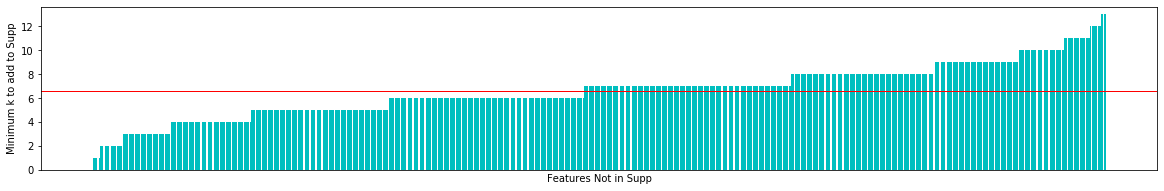

In [8]:
# Plot the results for all the features
plot_features_k_full(sorted_target_k_dict)

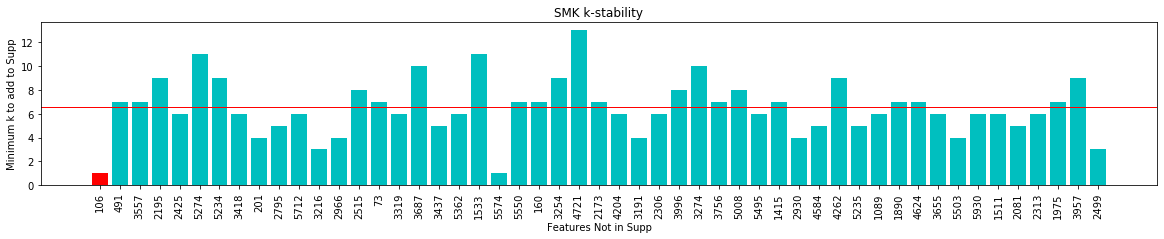

In [9]:
# Plot the results for random subset of size
size = 50
plot_features_k_random_subset(sorted_target_k_dict, size)

In [11]:
# Just for plotting the final images
import pickle
with open('PROSTATE_dict.pkl', 'wb') as file:
    pickle.dump(sorted_target_k_dict, file)